# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

print(f'x_train={x_train.shape}')
print(f'x_test={x_test.shape}')
print(f'y_train={y_train.shape}')
print(f'y_test={y_test.shape}')

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

print()
print(f'x_train={x_train.shape}')
print(f'x_test={x_test.shape}')
print(f'y_train={y_train.shape}')
print(f'y_test={y_test.shape}')

x_train=(50000, 32, 32, 3)
x_test=(10000, 32, 32, 3)
y_train=(50000, 1)
y_test=(10000, 1)

x_train=(50000, 3072)
x_test=(10000, 3072)
y_train=(50000, 10)
y_test=(10000, 10)


In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

ref:  
[Usage of optimizers](https://keras.io/optimizers/)

In [6]:
from keras import optimizers

## 超參數設定
EPOCHS = 50
BATCH_SIZE = 256

lr_list = [0.1, 0.01, 0.001, 0.0001]
#optimizer_names = ['sgd', 'rmsprop', 'adam', 'adagrad', 'adadelta', 'adamax', 'nadam'] 
optimizer_names = ['sgd', 'rmsprop', 'adam', 'adagrad'] 

In [7]:
def gen_optimizer(name, lr=0.01):
    if name == 'sgd':
        return optimizers.SGD(lr=lr, momentum=0.0, decay=0.0, nesterov=False)
    if name == 'rmsprop':
        return optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)
    if name == 'adam':
        return optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    if name == 'adagrad':
        return optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)
    if name == 'adadelta':
        return optimizers.Adadelta(lr=lr, rho=0.95, epsilon=None, decay=0.0)
    if name == 'adamax':
        return optimizers.Adamax(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    if name == 'nadam':
        return optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    return None

In [8]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for lr in lr_list:
    for op_name in optimizer_names:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print()
        print('-'*60)
        print(f"Experiment with LR = {lr}  optimizer={op_name}")
        model = build_mlp(input_shape=x_train.shape[1:])
        print(model.summary())
        
        optimizer = gen_optimizer(op_name, lr)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = f"op:{op_name}-lr:{str(lr)}"
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


------------------------------------------------------------
Experiment with LR = 0.1  optimizer=sgd
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
________________________

50000/50000 [==============================] - 17s 346us/step - loss: 0.8207 - acc: 0.7077 - val_loss: 1.5783 - val_acc: 0.5007
Epoch 47/50
50000/50000 [==============================] - 17s 339us/step - loss: 0.8122 - acc: 0.7095 - val_loss: 1.8423 - val_acc: 0.4688
Epoch 48/50
50000/50000 [==============================] - 19s 373us/step - loss: 0.7959 - acc: 0.7155 - val_loss: 1.9384 - val_acc: 0.4365
Epoch 49/50
50000/50000 [==============================] - 18s 353us/step - loss: 0.7662 - acc: 0.7259 - val_loss: 1.6251 - val_acc: 0.5033
Epoch 50/50
50000/50000 [==============================] - 17s 335us/step - loss: 0.7679 - acc: 0.7265 - val_loss: 1.7018 - val_acc: 0.5078

------------------------------------------------------------
Experiment with LR = 0.1  optimizer=rmsprop
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
________

50000/50000 [==============================] - 19s 371us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 46/50
50000/50000 [==============================] - 19s 376us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 47/50
50000/50000 [==============================] - 19s 384us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 19s 371us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 18s 365us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 19s 372us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000

------------------------------------------------------------
Experiment with LR = 0.1  optimizer=adam
_________________________________________________________

Epoch 45/50
50000/50000 [==============================] - 20s 397us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 46/50
50000/50000 [==============================] - 20s 403us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 47/50
50000/50000 [==============================] - 20s 410us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 20s 405us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 20s 405us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 20s 394us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000

------------------------------------------------------------
Experiment with LR = 0.1  optimizer=adagrad
__________________________________________

50000/50000 [==============================] - 18s 369us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 45/50
50000/50000 [==============================] - 18s 369us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 46/50
50000/50000 [==============================] - 19s 379us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 47/50
50000/50000 [==============================] - 18s 360us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 20s 408us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 49/50
50000/50000 [==============================] - 19s 372us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 50/50
50000/50000 [==============================] - 21s 415us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000

-----------------

50000/50000 [==============================] - 18s 368us/step - loss: 1.2786 - acc: 0.5521 - val_loss: 1.4326 - val_acc: 0.4926
Epoch 44/50
50000/50000 [==============================] - 19s 378us/step - loss: 1.2710 - acc: 0.5542 - val_loss: 1.4959 - val_acc: 0.4671
Epoch 45/50
50000/50000 [==============================] - 17s 348us/step - loss: 1.2657 - acc: 0.5571 - val_loss: 1.4013 - val_acc: 0.5045
Epoch 46/50
50000/50000 [==============================] - 17s 350us/step - loss: 1.2532 - acc: 0.5611 - val_loss: 1.4633 - val_acc: 0.4763
Epoch 47/50
50000/50000 [==============================] - 17s 347us/step - loss: 1.2520 - acc: 0.5607 - val_loss: 1.3719 - val_acc: 0.5166
Epoch 48/50
50000/50000 [==============================] - 17s 347us/step - loss: 1.2467 - acc: 0.5624 - val_loss: 1.4168 - val_acc: 0.5025
Epoch 49/50
50000/50000 [==============================] - 17s 346us/step - loss: 1.2376 - acc: 0.5652 - val_loss: 1.5950 - val_acc: 0.4457
Epoch 50/50
50000/50000 [=======

50000/50000 [==============================] - 20s 407us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 43/50
50000/50000 [==============================] - 20s 391us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 44/50
50000/50000 [==============================] - 20s 397us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 45/50
50000/50000 [==============================] - 20s 397us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 46/50
50000/50000 [==============================] - 19s 389us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 47/50
50000/50000 [==============================] - 20s 401us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 48/50
50000/50000 [==============================] - 21s 410us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 49/50
50000/

50000/50000 [==============================] - 19s 382us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 42/50
50000/50000 [==============================] - 20s 401us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 43/50
50000/50000 [==============================] - 19s 386us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 44/50
50000/50000 [==============================] - 19s 383us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 45/50
50000/50000 [==============================] - 19s 382us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 46/50
50000/50000 [==============================] - 19s 382us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 47/50
50000/50000 [==============================] - 19s 382us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 48/50
50000/

50000/50000 [==============================] - 18s 364us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 41/50
50000/50000 [==============================] - 18s 365us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 42/50
50000/50000 [==============================] - 18s 368us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 43/50
50000/50000 [==============================] - 18s 368us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 44/50
50000/50000 [==============================] - 18s 368us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 45/50
50000/50000 [==============================] - 18s 361us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 46/50
50000/50000 [==============================] - 18s 361us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 47/50
50000/

50000/50000 [==============================] - 16s 311us/step - loss: 1.7350 - acc: 0.3955 - val_loss: 1.7354 - val_acc: 0.3930
Epoch 41/50
50000/50000 [==============================] - 16s 311us/step - loss: 1.7306 - acc: 0.3965 - val_loss: 1.7331 - val_acc: 0.3941
Epoch 42/50
50000/50000 [==============================] - 16s 312us/step - loss: 1.7262 - acc: 0.3995 - val_loss: 1.7276 - val_acc: 0.3932
Epoch 43/50
50000/50000 [==============================] - 16s 311us/step - loss: 1.7222 - acc: 0.4010 - val_loss: 1.7243 - val_acc: 0.3962
Epoch 44/50
50000/50000 [==============================] - 16s 310us/step - loss: 1.7181 - acc: 0.4006 - val_loss: 1.7211 - val_acc: 0.3959
Epoch 45/50
50000/50000 [==============================] - 16s 311us/step - loss: 1.7140 - acc: 0.4020 - val_loss: 1.7162 - val_acc: 0.3982
Epoch 46/50
50000/50000 [==============================] - 16s 312us/step - loss: 1.7100 - acc: 0.4038 - val_loss: 1.7135 - val_acc: 0.3985
Epoch 47/50
50000/50000 [=======

50000/50000 [==============================] - 17s 350us/step - loss: 0.8921 - acc: 0.6790 - val_loss: 1.6872 - val_acc: 0.4925
Epoch 41/50
50000/50000 [==============================] - 18s 352us/step - loss: 0.8827 - acc: 0.6831 - val_loss: 1.7495 - val_acc: 0.4664
Epoch 42/50
50000/50000 [==============================] - 17s 349us/step - loss: 0.8733 - acc: 0.6885 - val_loss: 1.8040 - val_acc: 0.4907
Epoch 43/50
50000/50000 [==============================] - 17s 349us/step - loss: 0.8508 - acc: 0.6958 - val_loss: 1.7226 - val_acc: 0.4796
Epoch 44/50
50000/50000 [==============================] - 18s 351us/step - loss: 0.8423 - acc: 0.6992 - val_loss: 1.8485 - val_acc: 0.4862
Epoch 45/50
50000/50000 [==============================] - 17s 349us/step - loss: 0.8282 - acc: 0.7021 - val_loss: 1.7363 - val_acc: 0.4842
Epoch 46/50
50000/50000 [==============================] - 17s 349us/step - loss: 0.8151 - acc: 0.7081 - val_loss: 1.9732 - val_acc: 0.4671
Epoch 47/50
50000/50000 [=======

50000/50000 [==============================] - 18s 366us/step - loss: 0.8004 - acc: 0.7146 - val_loss: 1.5854 - val_acc: 0.5072
Epoch 41/50
50000/50000 [==============================] - 18s 367us/step - loss: 0.7869 - acc: 0.7199 - val_loss: 1.5540 - val_acc: 0.5256
Epoch 42/50
50000/50000 [==============================] - 18s 365us/step - loss: 0.7654 - acc: 0.7267 - val_loss: 1.5979 - val_acc: 0.5259
Epoch 43/50
50000/50000 [==============================] - 18s 367us/step - loss: 0.7413 - acc: 0.7351 - val_loss: 1.6324 - val_acc: 0.5215
Epoch 44/50
50000/50000 [==============================] - 18s 366us/step - loss: 0.7365 - acc: 0.7360 - val_loss: 1.6641 - val_acc: 0.5225
Epoch 45/50
50000/50000 [==============================] - 18s 365us/step - loss: 0.7201 - acc: 0.7454 - val_loss: 1.6937 - val_acc: 0.5121
Epoch 46/50
50000/50000 [==============================] - 18s 365us/step - loss: 0.7171 - acc: 0.7423 - val_loss: 1.7059 - val_acc: 0.5192
Epoch 47/50
50000/50000 [=======

50000/50000 [==============================] - 17s 333us/step - loss: 1.3011 - acc: 0.5483 - val_loss: 1.3851 - val_acc: 0.5085
Epoch 41/50
50000/50000 [==============================] - 17s 332us/step - loss: 1.2960 - acc: 0.5504 - val_loss: 1.3997 - val_acc: 0.5040
Epoch 42/50
50000/50000 [==============================] - 17s 332us/step - loss: 1.2910 - acc: 0.5525 - val_loss: 1.4010 - val_acc: 0.5044
Epoch 43/50
50000/50000 [==============================] - 17s 336us/step - loss: 1.2868 - acc: 0.5534 - val_loss: 1.4051 - val_acc: 0.5012
Epoch 44/50
50000/50000 [==============================] - 17s 333us/step - loss: 1.2823 - acc: 0.5550 - val_loss: 1.3776 - val_acc: 0.5129
Epoch 45/50
50000/50000 [==============================] - 17s 333us/step - loss: 1.2773 - acc: 0.5568 - val_loss: 1.3976 - val_acc: 0.5062
Epoch 46/50
50000/50000 [==============================] - 17s 334us/step - loss: 1.2727 - acc: 0.5581 - val_loss: 1.3789 - val_acc: 0.5088
Epoch 47/50
50000/50000 [=======

50000/50000 [==============================] - 16s 327us/step - loss: 2.0556 - acc: 0.2721 - val_loss: 2.0566 - val_acc: 0.2709
Epoch 40/50
50000/50000 [==============================] - 16s 317us/step - loss: 2.0520 - acc: 0.2733 - val_loss: 2.0530 - val_acc: 0.2713
Epoch 41/50
50000/50000 [==============================] - 16s 319us/step - loss: 2.0485 - acc: 0.2747 - val_loss: 2.0495 - val_acc: 0.2716
Epoch 42/50
50000/50000 [==============================] - 16s 313us/step - loss: 2.0451 - acc: 0.2753 - val_loss: 2.0462 - val_acc: 0.2729
Epoch 43/50
50000/50000 [==============================] - 17s 332us/step - loss: 2.0417 - acc: 0.2772 - val_loss: 2.0428 - val_acc: 0.2740
Epoch 44/50
50000/50000 [==============================] - 17s 332us/step - loss: 2.0384 - acc: 0.2784 - val_loss: 2.0395 - val_acc: 0.2759
Epoch 45/50
50000/50000 [==============================] - 16s 322us/step - loss: 2.0352 - acc: 0.2794 - val_loss: 2.0363 - val_acc: 0.2777
Epoch 46/50
50000/50000 [=======

50000/50000 [==============================] - 18s 364us/step - loss: 1.0652 - acc: 0.6307 - val_loss: 1.3998 - val_acc: 0.5135
Epoch 39/50
50000/50000 [==============================] - 18s 364us/step - loss: 1.0553 - acc: 0.6326 - val_loss: 1.3994 - val_acc: 0.5144
Epoch 40/50
50000/50000 [==============================] - 18s 359us/step - loss: 1.0458 - acc: 0.6355 - val_loss: 1.4230 - val_acc: 0.4998
Epoch 41/50
50000/50000 [==============================] - 19s 373us/step - loss: 1.0342 - acc: 0.6417 - val_loss: 1.3527 - val_acc: 0.5287
Epoch 42/50
50000/50000 [==============================] - 19s 381us/step - loss: 1.0223 - acc: 0.6445 - val_loss: 1.4024 - val_acc: 0.5190
Epoch 43/50
50000/50000 [==============================] - 18s 362us/step - loss: 1.0107 - acc: 0.6492 - val_loss: 1.4884 - val_acc: 0.4958
Epoch 44/50
50000/50000 [==============================] - 18s 362us/step - loss: 0.9995 - acc: 0.6527 - val_loss: 1.4163 - val_acc: 0.5139
Epoch 45/50
50000/50000 [=======

Epoch 38/50
50000/50000 [==============================] - 19s 372us/step - loss: 0.9490 - acc: 0.6692 - val_loss: 1.3433 - val_acc: 0.5414ETA: 1s - loss: 0.9487 -
Epoch 39/50
50000/50000 [==============================] - 19s 374us/step - loss: 0.9370 - acc: 0.6744 - val_loss: 1.3368 - val_acc: 0.5397loss: 0. - ETA: 4s - loss: 0.930
Epoch 40/50
50000/50000 [==============================] - 19s 375us/step - loss: 0.9244 - acc: 0.6785 - val_loss: 1.3389 - val_acc: 0.5423
Epoch 41/50
50000/50000 [==============================] - 19s 376us/step - loss: 0.9149 - acc: 0.6832 - val_loss: 1.3228 - val_acc: 0.5477
Epoch 42/50
50000/50000 [==============================] - 19s 375us/step - loss: 0.9023 - acc: 0.6887 - val_loss: 1.3284 - val_acc: 0.5391
Epoch 43/50
50000/50000 [==============================] - 19s 375us/step - loss: 0.8917 - acc: 0.6927 - val_loss: 1.3746 - val_acc: 0.53308
Epoch 44/50
50000/50000 [==============================] - 19s 377us/step - loss: 0.8803 - acc: 0.6960 

50000/50000 [==============================] - 18s 360us/step - loss: 1.6777 - acc: 0.4214 - val_loss: 1.6858 - val_acc: 0.4112
Epoch 38/50
50000/50000 [==============================] - 18s 364us/step - loss: 1.6755 - acc: 0.4218 - val_loss: 1.6835 - val_acc: 0.4120
Epoch 39/50
50000/50000 [==============================] - 18s 355us/step - loss: 1.6731 - acc: 0.4228 - val_loss: 1.6812 - val_acc: 0.4129
Epoch 40/50
50000/50000 [==============================] - 20s 391us/step - loss: 1.6709 - acc: 0.4227 - val_loss: 1.6793 - val_acc: 0.4158
Epoch 41/50
50000/50000 [==============================] - 18s 360us/step - loss: 1.6686 - acc: 0.4234 - val_loss: 1.6777 - val_acc: 0.4145
Epoch 42/50
50000/50000 [==============================] - 20s 408us/step - loss: 1.6663 - acc: 0.4244 - val_loss: 1.6752 - val_acc: 0.4144
Epoch 43/50
50000/50000 [==============================] - 18s 356us/step - loss: 1.6641 - acc: 0.4261 - val_loss: 1.6729 - val_acc: 0.4151
Epoch 44/50
50000/50000 [=======

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_legend(label):
    legend = label
    legend = legend.replace('op:', '')
    legend = legend.replace('lr:', '')
    return legend

def plot_data(results, title=''):
    plt.clf()
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 4)
    #plt.subplots_adjust(bottom=.05, top=.9, hspace=.5)

    fig.suptitle(title)

    for i, cond in enumerate(results.keys()):
        legend_label = get_legend(cond)
        ax1.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=legend_label, color=color_bar[i])
        ax1.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=legend_label, color=color_bar[i])
    ax1.set_title("Loss")
    #ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.legend(loc='best')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    for i, cond in enumerate(results.keys()):
        legend_label = get_legend(cond)
        ax2.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=legend_label, color=color_bar[i])
        ax2.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=legend_label, color=color_bar[i])
    ax2.set_title("Accuracy")
    #ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.legend(loc='best')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
   
    plt.show()

<Figure size 432x288 with 0 Axes>

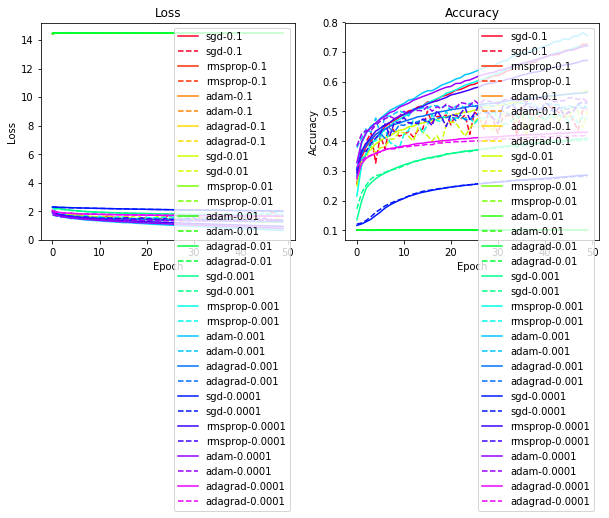

In [10]:
plot_data(results)

<Figure size 432x288 with 0 Axes>

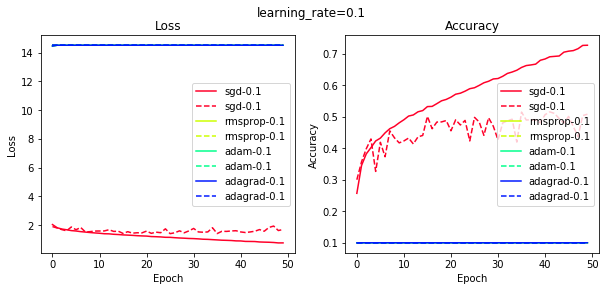

<Figure size 432x288 with 0 Axes>

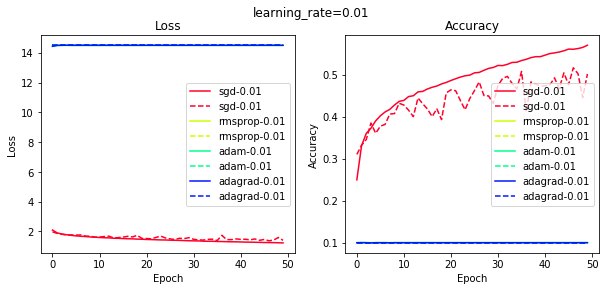

<Figure size 432x288 with 0 Axes>

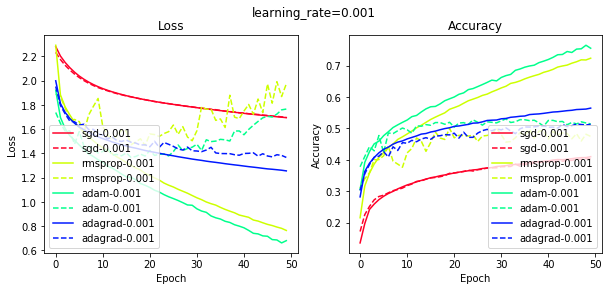

<Figure size 432x288 with 0 Axes>

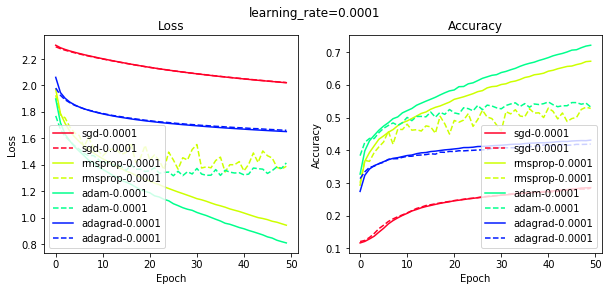

In [11]:
for lr in lr_list:
    results_by_learning_rate = {k: v for k, v in results.items() if f'lr:{str(lr)}' in k}
    plot_data(results_by_learning_rate, title=f'learning_rate={lr}')

<Figure size 432x288 with 0 Axes>

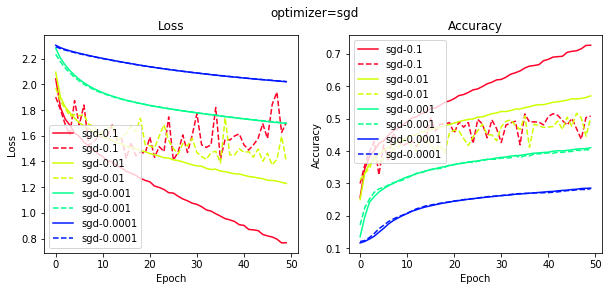

<Figure size 432x288 with 0 Axes>

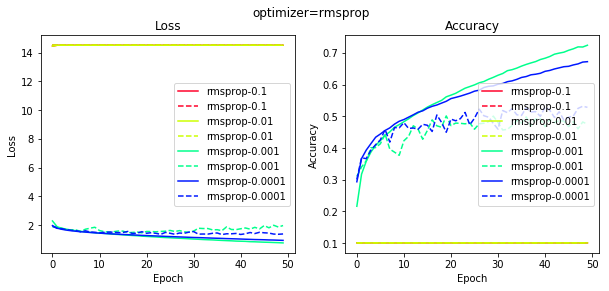

<Figure size 432x288 with 0 Axes>

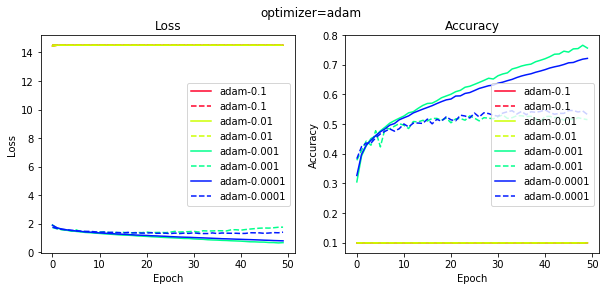

<Figure size 432x288 with 0 Axes>

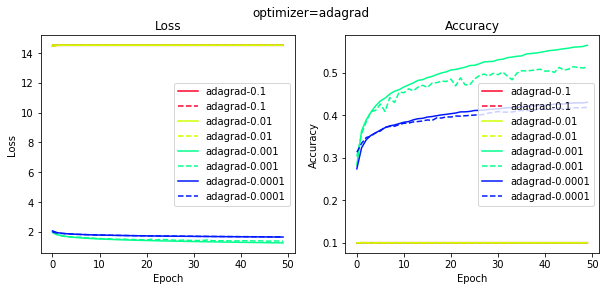

In [12]:
for op_name in optimizer_names:
    results_by_optimizer = {k: v for k, v in results.items() if f'op:{op_name}' in k}
    plot_data(results_by_optimizer, title=f'optimizer={op_name}')